# Overview
To facilitate rapid prototyping, the Dune-Python module
(https://www.dune-project.org/modules/dune-python)
provides Python classes for all the core interfaces of Dune. This makes
it easy to develop algorithms directly in Python which go beyond what is
available through the Dune-Fem discretization module. This is especially
of interest for pre- and postprocessing part of the overall simulation
package. While most interface methods from the Dune-Fem package are
high level, i.e., computationally expensive, many of the core Dune
interface methods are not, i.e., the methods for computing the geometric
representation of an element or the methods required to iterate over a
grid. Consequently, depending on the requirements of the developed code
parts, using the Dune core interfaces through Python could incur a too high
hit on the performance of the code. Since the exported Python interfaces
are very close to the original Dune C++ interfaces, transferring a Python
prototype of the algorithm to C++ is mostly straightforward. A just in
time compilation utility available in Dune-Python makes it then very easy
to use these C++ algorithms_ from within Python.

In the following we briefly introduce the most important parts of the
Dune core interface

.. _algorithms: topics.rst

# Dense Vectors and the Geometry Classes
A quick survey of Dune-Common and Dune-Geometry
The core module Dune-Common provides some classes for dense linear algebra.
The `FieldVector` and `FieldMatrix` classes are heavily used in the grid
geometry realizations. The conceptional basis for these geometries is
provided by Dune-Geometry, providing, for example, reference elements and
quadrature rules.

In [1]:
import time, numpy, math, sys
import matplotlib.pyplot as pyplot
from dune.common import FieldVector, FieldMatrix
x = FieldVector([0.25,0.25,0.25])

import dune.geometry
geometryType = dune.geometry.simplex(2)
referenceElement = dune.geometry.referenceElement(geometryType)
print("\t".join(str(c) for c in referenceElement.corners))

for p in dune.geometry.quadratureRule(geometryType, 3):
    print(p.position, p.weight)

(0.000000, 0.000000)	(1.000000, 0.000000)	(0.000000, 1.000000)
(0.333333, 0.333333) -0.28125
(0.600000, 0.200000) 0.2604166666666667
(0.200000, 0.600000) 0.2604166666666667
(0.200000, 0.200000) 0.2604166666666667


# Grid Construction and Basic Interface
We now move on to the Dune-Grid module. First let us discuss different
possibilities of constructing a grid.

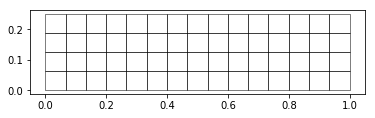

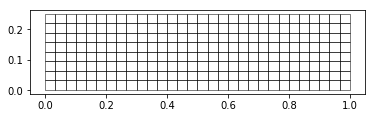

In [2]:
from dune.grid import cartesianDomain, yaspGrid
domain = cartesianDomain([0, 0], [1, 0.25], [15, 4])
yaspView = yaspGrid(domain)

yaspView.plot()
yaspView.hierarchicalGrid.globalRefine()
yaspView.plot()
pyplot.show()

Let's visualize the grid and then globally refine it once

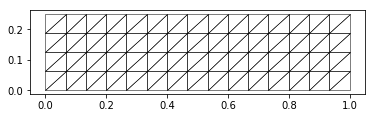

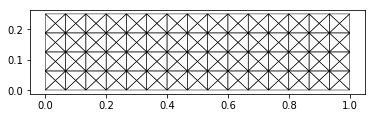

In [3]:
from dune.alugrid import aluConformGrid
aluView = aluConformGrid(domain)
aluView.plot()
aluView.hierarchicalGrid.globalRefine()
aluView.plot()

The same for setting up a simplex grid

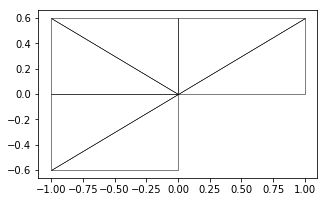

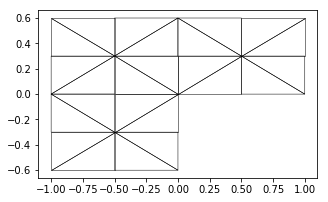

In [4]:
vertices = [(0,0), (1,0), (1,0.6), (0,0.6), (-1,0.6), (-1,0), (-1,-0.6), (0,-0.6)]
triangles = [(2,0,1), (0,2,3), (4,0,3), (0,4,5), (6,0,5), (0,6,7)]
aluView = aluConformGrid({"vertices": vertices, "simplices": triangles})
aluView.plot(figsize=(5,5))
aluView.hierarchicalGrid.globalRefine(2)
aluView.plot(figsize=(5,5))

In addition to global refinement we can also pre process the grid by
marking a subset of elements for local refinement.

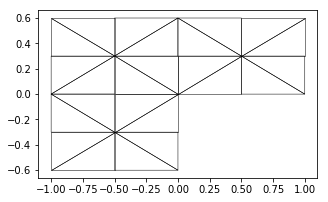

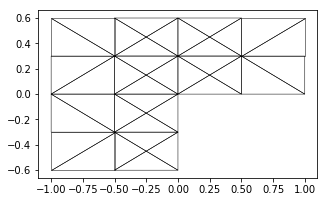

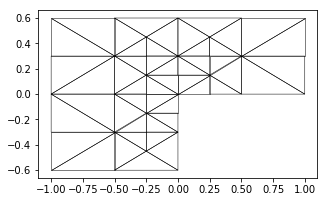

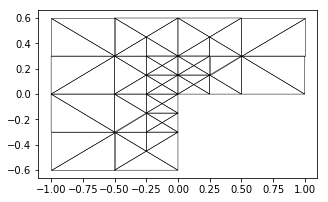

In [5]:
from dune.grid import Marker
aluView.plot(figsize=(5,5))
for i in range(1,4):
    def mark(e):
        x = e.geometry.center
        return Marker.refine if x.two_norm < 0.64**i else Marker.keep
    aluView.hierarchicalGrid.adapt(mark)
    aluView.plot(figsize=(5,5))

from dune.alugrid import aluSimplexGrid
vertices = aluView.coordinates()
triangles = [aluView.indexSet.subIndices(e, 2) for e in aluView.elements]
aluView = aluSimplexGrid({"vertices": vertices, "simplices": triangles})

We next discuss how to retrieve basic information from a constructed grid
and iterate over its entities (i.e., elements, faces, edges, vertices, etc.).

In [6]:
vertices = [(0,0), (1,0), (1,1), (0,1)]
triangles = [(2,0,1), (0,2,3)]
unitSquare = aluSimplexGrid({"vertices": vertices, "simplices": triangles})
print(unitSquare.size(0),"elements and",unitSquare.size(2),"vertices")

for codim in range(0, unitSquare.dimension+1):
    for entity in unitSquare.entities(codim):
        print(", ".join(str(c) for c in entity.geometry.corners))

for edge in unitSquare.edges:
    print(", ".join(str(c) for c in edge.geometry.corners))

2 elements and 4 vertices
(1.000000, 1.000000), (1.000000, 0.000000), (0.000000, 0.000000)
(0.000000, 0.000000), (0.000000, 1.000000), (1.000000, 1.000000)
(0.000000, 0.000000), (1.000000, 0.000000)
(0.000000, 0.000000), (1.000000, 1.000000)
(0.000000, 0.000000), (0.000000, 1.000000)
(1.000000, 0.000000), (1.000000, 1.000000)
(1.000000, 1.000000), (0.000000, 1.000000)
(0.000000, 0.000000)
(1.000000, 0.000000)
(1.000000, 1.000000)
(0.000000, 1.000000)
(0.000000, 0.000000), (1.000000, 0.000000)
(0.000000, 0.000000), (1.000000, 1.000000)
(0.000000, 0.000000), (0.000000, 1.000000)
(1.000000, 0.000000), (1.000000, 1.000000)
(1.000000, 1.000000), (0.000000, 1.000000)


# Attaching Data to the Grid and Defining Grid Functions
This is a fundamental concept in any grid based discretization package.
These are functions that can be evaluated given an entity in the grid and
a local coordinate within the reference element of that entity.

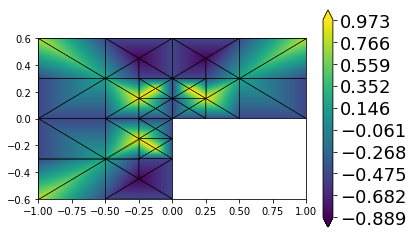

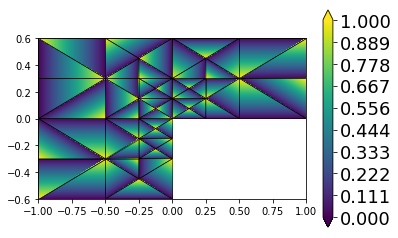

In [7]:
@dune.grid.gridFunction(aluView)
def f(x):
    return math.cos(2.*math.pi/(0.3+abs(x[0]*x[1])))

@dune.grid.gridFunction(aluView)
def hat0(element,hatx):
    return 1-hatx[0]-hatx[1]

hatx = FieldVector([1./3., 1./3.])
maxValue = max(f(e, hatx) for e in f.grid.elements)

maxValue = max(f(e.geometry.toGlobal(hatx)) for e in f.grid.elements)

f.plot()
hat0.plot()

To attach data to the entities in a grid, each Dune grid has an
`IndexSet` which provides a consecutive, zero starting integer for the
set of entities of a given geometry type, i.e., entities sharing the same
reference element, like all triangles or all cubes. This can be used to attach
data to the these entities stored in random access containers like
`numpy` arrays. To simplify the process further a `mapper` can be used
which is initialized with the data layout, i.e., the number of degrees of
freedom that is supposed to be attached to every entity with a given
geometry type.

In [8]:
mapper = unitSquare.mapper([2, 0, 3])

layout = {dune.geometry.quadrilateral: 4, dune.geometry.triangle: 1}
mapper = unitSquare.mapper(layout)

def interpolate(grid):
    mapper = grid.mapper({dune.geometry.vertex: 1})
    data = numpy.zeros(mapper.size)
    for v in grid.vertices:
        data[mapper.index(v)] = f(v.geometry.center)
    return mapper, data

mapper, data = interpolate(aluView)
@dune.grid.gridFunction(aluView)
def p12dEvaluate(e, x):
    bary = 1-x[0]-x[1], x[0], x[1]
    idx = mapper.subIndices(e, 2)
    return sum(b * data[i] for b, i in zip(bary, idx))

@dune.grid.gridFunction(aluView)
def error(e, x):
    return abs(p12dEvaluate(e, x)-f(e, x))
hatx = FieldVector([1./3., 1./3.])
print(max(error(e, hatx) for e in aluView.elements))

1.6026566867981322


# Output of Grid and Visualization of Data
We already used `matplotlib` to plot the grid and grid functions. For more
flexible plotting Dune relies on `vtk` and Dune-Python makes it easy to
write suitable files.

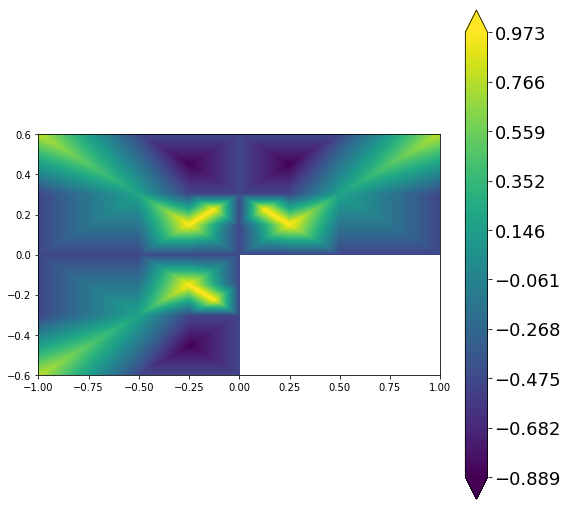

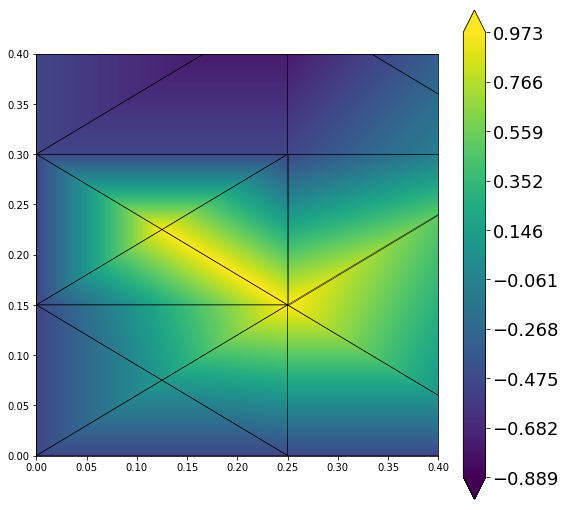

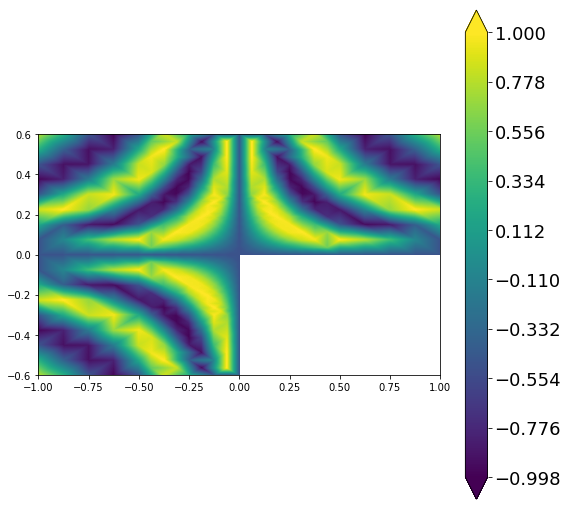

In [9]:
p12dEvaluate.plot(figsize=(9,9), gridLines=None)
p12dEvaluate.plot(figsize=(9,9), gridLines='black',
             xlim=[0,0.4], ylim=[0,0.4])
f.plot(level=2, figsize=(9,9), gridLines=None)

pd = {"exact": f, "discrete": p12dEvaluate, "error": error}
aluView.writeVTK("interpolation", pointdata=pd)

aluView.writeVTK("interpolation_subsampled", subsampling=2, pointdata=pd)

![interpolation](figures/interpolation_discrete.png)
![exact solution](figures/interpolation_exact.png)
![interpolation error](figures/interpolation_error.png)

Mayavi can also be used to plot grid function in Python. This approach
relies on methods to extract `numpy` representations of the grid data
structure and values of a given grid function.

__Note__: mayavi is not installed in the Docker image and, therefore,
this feature is not available the Docker container.

Notebook initialized with png backend.



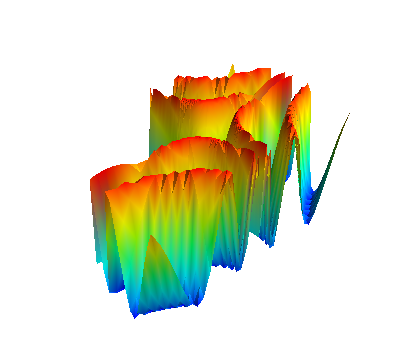

In [10]:
level = 3
triangulation = f.grid.triangulation(level)
z = f.pointData(level)[:,0]
try:
    from mayavi import mlab
    from mayavi.tools.notebook import display
    mlab.init_notebook("png")
    mlab.figure(bgcolor = (1,1,1))
    s = mlab.triangular_mesh(triangulation.x, triangulation.y, z*0.5,
                             triangulation.triangles)
    display( s )
    # mlab.savefig("mayavi.png", size=(400,300))
    mlab.close(all=True)
except ImportError:
    pass